In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import george

#Our expensive simulation model for the forwar calculations of the likelihood
import run_simple_energy_loss


from approxposterior import approx, gpUtils as gpu

**Data**

---

First, we generate data from our jet energy loss simulations and assume  indepedent, Gaussian errors, for the measurement of $R_{AA}$.

In [2]:
simulation=run_simple_energy_loss.run_simulation

In [3]:
# Wrap the simulation in a way that it only takes the parameter alpha_s, m_D norm as input and keep all other model
# parameters fixed. p_T values have to be discrete and between 1 and 10.
def f(alpha_s, mD_factor, p_T_values):
    """returns simulation output for alpha_s design point"""
    
    n_design=1
   # print(n_design)
    p_mom=(1, 10, 10)
    # design for alpha_s parameter
    T0_in_fm = np.full((n_design,1), 0.3)
    tau0 = np.full((n_design,1), 0.2)
    Tf_in_fm = np.full((n_design,1), 0.15)
    # We will only consider the change in modle parameter for now
    alpha_s = alpha_s.reshape(-1,1)
    mD_factor = mD_factor.reshape(-1,1)
    design = np.hstack([T0_in_fm, tau0, Tf_in_fm, alpha_s, mD_factor])
    #print(design.shape)
    observables=simulation(design,*p_mom)
    
    #Let's just return only one obsrvable for now. The middle p_T bin
    p_T_bins=np.array(p_T_values).flatten()
    return observables[:,p_T_bins]

Working on 0/1 designs


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


Shape of the result array is (1, 10)


Text(0.5, 1.0, 'Experimental observations')

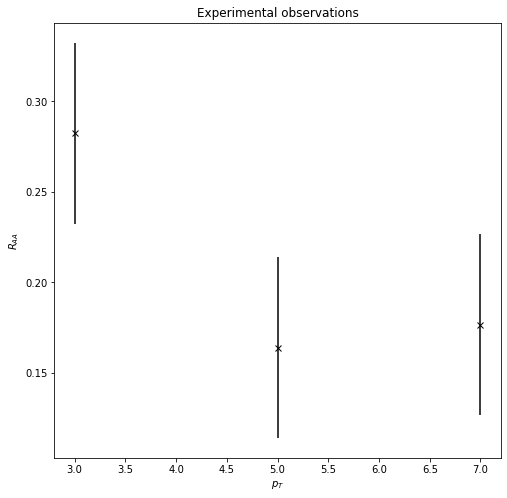

In [4]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Choose the "true" parameters.
alpha_s_true = np.array([0.3])
mD_factor_true  = np.array([2])


# Generate some synthetic data from the model.
x = np.array([3, 5, 7])
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = f(alpha_s_true, mD_factor_true, x) # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')

**Inference**

---

Now we want to infer posterior probability distributions for our model's parameters, $\theta$, i.e $\alpha_s$, given the data and uncertainties, D, via Bayes' Theorem: $p(\theta | D) \propto l(D | \theta)p(\theta)$ where $l(D|\theta)$ is the likelihood of the data for a given set of model parameters, and $p(\theta)$ is our assume prior probability of a given $\theta$. We sample the posterior distribution using the emcee MCMC code.  See the emcee example (https://emcee.readthedocs.io/en/latest/tutorials/line/) for more details of this procedure.

In [5]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    alpha_s, mD_factor = theta
    
    # Model predictions given parameters
    model = f(alpha_s, mD_factor, x)
    
    # Likelihood of data given model parameters
    return -0.5*np.sum((obs-model)**2/obserr**2)

In [6]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, mD_factor = theta
    
    # Probability of model parameters: flat prior
    if 0 < alpha_s < 1 and 0 < mD_factor < 5:
        return 0.0
    return -np.inf

In [7]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logProbability(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

**Inference with ```approxposterior```**

---

Now let's see if we can derive similar constraints using ```approxposterior```.

First, ```approxposterior``` requires a function that samples model parameters from the prior distributions.

In [11]:
def sampleFunction(n):
    """
    docs

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 3 array of floats samples from the prior
    """

    # Sample model parameters given prior distributions
    alpha_s = np.random.uniform(size=(n))
    mD_norm = np.random.uniform(low=0, high=5, size=(n))
   # b = np.random.uniform(low=0, high=10, size=(n))
    
    return np.array([alpha_s, mD_norm]).T
# end function

Define the ```approxposterior``` parameters.

In [12]:
# Define algorithm parameters
m0 = 5                           # Initial size of training set
m = 10                            # Number of new points to find each iteration
nmax = 5                          # Maximum number of iterations
bounds = [(0,1),(0,5)]    # Prior bounds
algorithm = "bape"                # Use the Kandasamy et al. (2017) formalism

# emcee MCMC parameters: Use the same MCMC parameters as the emcee-only analysis
samplerKwargs = {"nwalkers" : 5}  # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : 5000} # emcee.EnsembleSampler.run_mcmc parameters

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr)

Here we create the initial training set by running the true forward model $m_0$ times.  ```approxposterior``` learns on this training set and, each iteration, runs the forward model $m$ additional times in regions of parameter space that will most improve its owns predictive performance, iteratively improving the posterior distribution estimate.

In [13]:
# Create a training set to condition the GP

# Randomly sample initial conditions from the prior
theta = np.array(sampleFunction(m0))

# Evaluate forward model to compute log likelihood + lnprior for each theta
y = list()
for ii in range(len(theta)):
    y.append(logLikelihood(theta[ii,:], *args) + logPrior(theta[ii,:]))
y = np.array(y)

# We'll create the initial GP using approxposterior's built-in default
# initialization.  This default typically works well in many applications.
gp = gpu.defaultGP(theta, y)

Working on 0/1 designs
Shape of the result array is (1, 10)
Working on 0/1 designs
Shape of the result array is (1, 10)
Working on 0/1 designs
Shape of the result array is (1, 10)
Working on 0/1 designs


/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:42: RuntimeWarning: invalid value encountered in log
  log_P_g_prev=np.log(P_g)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:74: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res_quad2c=scipy.integrate.quad(vec_integrand, p, pmax, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:77: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p*(1-delta), limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The occurrence of roundoff error is detected, which pr

Shape of the result array is (1, 10)
Working on 0/1 designs
Shape of the result array is (1, 10)


Now initialize the ```ApproxPosterior``` object and we're ready to go!

In [14]:
ap = approx.ApproxPosterior(theta=theta,                   # Initial model parameters for inputs
                            y=y,                           # Logprobability of each input
                            gp=gp,                         # Initialize Gaussian Process
                            lnprior=logPrior,              # logprior function
                            lnlike=logLikelihood,          # loglikelihood function
                            priorSample=sampleFunction,    # Prior sample function
                            algorithm=algorithm,           # bape, agp, or alternate
                            bounds=bounds)                 # Parameter bounds

Run ```approxposterior```! Note that we set cache to False so ```approxposterior``` only saves the most recent sampler and MCMC chain instead of saving each full MCMC chain to a local HD5f file (see emcee v3 documentation for more details on how emcee caches data).

In [15]:
# Run!
ap.run(m=m, nmax=nmax,estBurnin=True, mcmcKwargs=mcmcKwargs, cache=False,
       samplerKwargs=samplerKwargs, verbose=False, args=args, onlyLastMCMC=True,
       seed=seed)

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  0%|          | 0/10 [00:00<?, ?it/s]

Working on 0/1 designs


 10%|█         | 1/10 [02:40<24:08, 160.92s/it]

Shape of the result array is (1, 10)
hyperparameters [-145.0129453   -14.78349568   -3.28864441]
Working on 0/1 designs


 20%|██        | 2/10 [02:51<09:39, 72.38s/it] 

Shape of the result array is (1, 10)
hyperparameters [-125.43915243  -14.7932839    -3.28184452]
Working on 0/1 designs


 30%|███       | 3/10 [03:19<06:03, 51.99s/it]

Shape of the result array is (1, 10)
hyperparameters [-125.77760902   -3.94177893   -1.61229298]
Working on 0/1 designs


 40%|████      | 4/10 [05:54<09:17, 92.87s/it]

Shape of the result array is (1, 10)
hyperparameters [-125.85112294   -4.13411578   -1.62134899]
Working on 0/1 designs


 50%|█████     | 5/10 [10:12<12:41, 152.25s/it]

Shape of the result array is (1, 10)
hyperparameters [-125.81962263   -4.11501845   -1.62002359]
Working on 0/1 designs


 60%|██████    | 6/10 [10:41<07:21, 110.43s/it]

Shape of the result array is (1, 10)
hyperparameters [-125.79966406   -4.10739436   -1.61590261]
Working on 0/1 designs


 70%|███████   | 7/10 [11:08<04:10, 83.34s/it] 

Shape of the result array is (1, 10)
hyperparameters [-125.6361339    -4.0350364    -1.60612937]
Working on 0/1 designs


 80%|████████  | 8/10 [11:33<02:09, 64.58s/it]

Shape of the result array is (1, 10)
hyperparameters [-118.02315791   -4.90586522   -1.57735449]
Working on 0/1 designs


 90%|█████████ | 9/10 [11:46<00:48, 48.61s/it]

Shape of the result array is (1, 10)
hyperparameters [-115.70597852   -5.30414472   -1.51946392]
Working on 0/1 designs


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of the result array is (1, 10)
hyperparameters [-115.73948889   -5.0108718    -1.52310425]
Working on 0/1 designs


 10%|█         | 1/10 [00:15<02:17, 15.31s/it]

Shape of the result array is (1, 10)
hyperparameters [-115.10901541   -4.61929349   -1.52976793]
Working on 0/1 designs


 20%|██        | 2/10 [00:29<01:55, 14.38s/it]

Shape of the result array is (1, 10)
hyperparameters [-110.26256586   -4.46309952   -1.40139768]
Working on 0/1 designs


 30%|███       | 3/10 [00:42<01:37, 13.93s/it]

Shape of the result array is (1, 10)
hyperparameters [-110.30511408   -4.44094914   -1.39676147]
Working on 0/1 designs


 40%|████      | 4/10 [00:56<01:23, 13.93s/it]

Shape of the result array is (1, 10)
hyperparameters [-111.64663185   -4.49830877   -1.54579368]
Working on 0/1 designs


 50%|█████     | 5/10 [01:09<01:08, 13.80s/it]

Shape of the result array is (1, 10)
hyperparameters [-106.34468951   -4.84737886   -1.36165527]
Working on 0/1 designs


 60%|██████    | 6/10 [01:23<00:54, 13.69s/it]

Shape of the result array is (1, 10)
hyperparameters [-105.42044677   -4.94883425   -1.34717711]
Working on 0/1 designs


 70%|███████   | 7/10 [01:37<00:41, 13.94s/it]

Shape of the result array is (1, 10)
hyperparameters [-105.87218674   -4.85711875   -1.34846304]
Working on 0/1 designs


 80%|████████  | 8/10 [01:52<00:28, 14.19s/it]

Shape of the result array is (1, 10)
hyperparameters [-97.79909714  -5.43792804  -1.2732881 ]
Working on 0/1 designs


 90%|█████████ | 9/10 [02:05<00:13, 13.94s/it]

Shape of the result array is (1, 10)
hyperparameters [-97.6437879   -5.40491881  -1.28100356]
Working on 0/1 designs


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of the result array is (1, 10)
hyperparameters [-97.47321842  -5.40850339  -1.27832888]
Working on 0/1 designs


 10%|█         | 1/10 [00:13<02:00, 13.36s/it]

Shape of the result array is (1, 10)
hyperparameters [-97.29265474  -5.33548711  -1.24946034]
Working on 0/1 designs


 20%|██        | 2/10 [00:26<01:45, 13.23s/it]

Shape of the result array is (1, 10)
hyperparameters [-95.64058972  -5.44114945  -1.19432145]
Working on 0/1 designs


 30%|███       | 3/10 [04:44<14:33, 124.80s/it]

Shape of the result array is (1, 10)
hyperparameters [-40.8214299   -1.7399636  -16.72750464]
Working on 0/1 designs


 40%|████      | 4/10 [05:01<08:15, 82.56s/it] 

Shape of the result array is (1, 10)
hyperparameters [-93.83863779  -5.42633736  -1.18336813]
Working on 0/1 designs


 50%|█████     | 5/10 [05:15<04:48, 57.73s/it]

Shape of the result array is (1, 10)
hyperparameters [-89.46142063  -5.65980087  -1.10197219]
Working on 0/1 designs


 60%|██████    | 6/10 [05:29<02:51, 42.77s/it]

Shape of the result array is (1, 10)
hyperparameters [-88.67560384  -5.65831736  -1.10048113]
Working on 0/1 designs


 70%|███████   | 7/10 [05:42<01:39, 33.20s/it]

Shape of the result array is (1, 10)
hyperparameters [-88.51048339  -5.65078379  -1.09806104]
Working on 0/1 designs


 80%|████████  | 8/10 [05:50<00:50, 25.08s/it]

Shape of the result array is (1, 10)
hyperparameters [-35.14917239  -2.09796004 -17.05393065]
Working on 0/1 designs


 90%|█████████ | 9/10 [06:04<00:21, 21.53s/it]

Shape of the result array is (1, 10)
hyperparameters [-113.79841174   -4.64349091   -1.39167675]
Working on 0/1 designs


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of the result array is (1, 10)
hyperparameters [-113.70489019   -4.67275663   -1.36388625]
Working on 0/1 designs


 10%|█         | 1/10 [00:14<02:08, 14.27s/it]

Shape of the result array is (1, 10)
hyperparameters [-113.15087883   -4.67973155   -1.37086616]
Working on 0/1 designs


 20%|██        | 2/10 [00:27<01:50, 13.87s/it]

Shape of the result array is (1, 10)
hyperparameters [-114.00743428   -4.78941052   -1.59735428]
Working on 0/1 designs


 30%|███       | 3/10 [00:41<01:37, 13.97s/it]

Shape of the result array is (1, 10)
hyperparameters [-114.08573404   -4.79000442   -1.58866141]
Working on 0/1 designs


 40%|████      | 4/10 [00:56<01:24, 14.13s/it]

Shape of the result array is (1, 10)
hyperparameters [-114.13977011   -4.93835462   -1.49889473]
Working on 0/1 designs


 50%|█████     | 5/10 [01:10<01:10, 14.03s/it]

Shape of the result array is (1, 10)
hyperparameters [-112.41181614   -4.83000061   -1.52248232]
Working on 0/1 designs


 60%|██████    | 6/10 [01:24<00:56, 14.13s/it]

Shape of the result array is (1, 10)
hyperparameters [-110.4722106    -4.53310547   -2.00923352]
Working on 0/1 designs


 70%|███████   | 7/10 [01:38<00:41, 13.95s/it]

Shape of the result array is (1, 10)
hyperparameters [-110.13075638   -4.55588871   -1.98775342]
Working on 0/1 designs


 80%|████████  | 8/10 [04:22<02:03, 61.90s/it]

Shape of the result array is (1, 10)
hyperparameters [-109.90470119   -4.5456144    -1.99734059]
Working on 0/1 designs


 90%|█████████ | 9/10 [06:54<01:30, 90.01s/it]

Shape of the result array is (1, 10)
hyperparameters [-109.98925612   -4.55353424   -1.9872696 ]
Working on 0/1 designs


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of the result array is (1, 10)
hyperparameters [-35.27906841  -3.11837572 -16.74730948]
Working on 0/1 designs
Shape of the result array is (1, 10)
hyperparameters [-109.71291791   -4.5699716    -2.00051948]


 10%|█         | 1/10 [00:13<02:04, 13.80s/it]

Working on 0/1 designs


 20%|██        | 2/10 [00:27<01:48, 13.59s/it]

Shape of the result array is (1, 10)
hyperparameters [-108.84648888   -4.55284399   -1.95096157]
Working on 0/1 designs


 30%|███       | 3/10 [00:40<01:34, 13.47s/it]

Shape of the result array is (1, 10)
hyperparameters [-107.90860334   -4.56251309   -1.89981587]
Working on 0/1 designs


 40%|████      | 4/10 [03:14<06:52, 68.76s/it]

Shape of the result array is (1, 10)
hyperparameters [-107.72653659   -4.54500514   -1.89762084]
Working on 0/1 designs


 50%|█████     | 5/10 [03:27<04:04, 48.94s/it]

Shape of the result array is (1, 10)
hyperparameters [-105.93435776   -4.56025004   -1.87845853]
Working on 0/1 designs


 60%|██████    | 6/10 [03:43<02:29, 37.50s/it]

Shape of the result array is (1, 10)
hyperparameters [-104.81095116   -4.56028424   -1.89043616]
Working on 0/1 designs


 70%|███████   | 7/10 [03:58<01:30, 30.11s/it]

Shape of the result array is (1, 10)
hyperparameters [-104.42058559   -4.5333972    -2.1978996 ]
Working on 0/1 designs


 80%|████████  | 8/10 [04:11<00:49, 24.89s/it]

Shape of the result array is (1, 10)
hyperparameters [-104.57261078   -4.54311936   -2.19831578]
Working on 0/1 designs


 90%|█████████ | 9/10 [04:25<00:21, 21.43s/it]

Shape of the result array is (1, 10)
hyperparameters [-103.26478639   -4.50610828   -2.17510667]
Working on 0/1 designs


100%|██████████| 10/10 [04:39<00:00, 27.93s/it]

Shape of the result array is (1, 10)
hyperparameters [-103.06452976   -4.52148118   -2.173509  ]


As before, let's plot the joint and marginal posterior probability distributions to see how ```approxposterior``` did. In addition, as red points, we'll plot where ```approxposterior``` decided to evaluate the forward model to improve its own performance.  As you'll see below, ```approxposterior``` preferentially runs the forward model in regions of high posterior probability density - it doesn't waste time on low likelihood regions of parameter space!

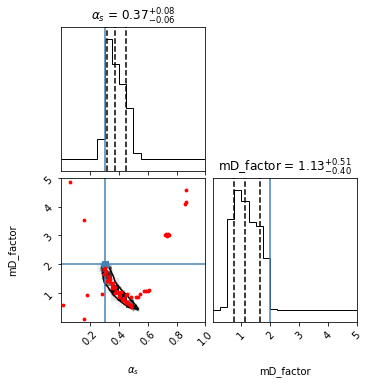

In [16]:
samples = ap.sampler.get_chain(discard=500, flat=True, thin=1)

fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], truths=[alpha_s_true, mD_factor_true],
                    labels=[r"$\alpha_s$", "mD_factor"], show_titles=True, scale_hist=True,
                    plot_contours=True, range=([0,1],[0, 5]));

# Plot where forward model was evaluated
fig.axes[2].scatter(ap.theta[:,0], ap.theta[:,1], s=8, color="red", zorder=20);

The predictions are close to the true MCMC!